# 03-3: JAX intro

JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.

JAX is much more than just a GPU-backed NumPy. It also comes with a few program transformations that are useful when writing numerical code. For now, there's three main ones:

 - `jit`, for speeding up your code
 - `grad`, for taking derivatives
 - `vmap`, for automatic vectorization or batching.

With its updated version of [Autograd](https://github.com/hips/autograd), JAX can automatically differentiate native Python and NumPy code. It can differentiate through a large subset of Python’s features, including loops, ifs, recursion, and closures, and it can even take derivatives of derivatives of derivatives. It supports reverse-mode as well as forward-mode differentiation, and the two can be composed arbitrarily to any order.

What’s new is that JAX uses [XLA](https://www.tensorflow.org/xla) to compile and run your NumPy code on accelerators, like GPUs and TPUs.
Compilation happens under the hood by default, with library calls getting just-in-time compiled and executed. But JAX even lets you just-in-time compile your own Python functions into XLA-optimized kernels using a one-function API. Compilation and automatic differentiation can be composed arbitrarily, so you can express sophisticated algorithms and get maximal performance without having to leave Python.

In [57]:
#!pip install jax

In [58]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

# JAX is "Numpy on GPUs/TPUs"



You can use most numpy functions in JAX numpy

In [59]:
import numpy as np
x = jnp.arange(10)
x

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [60]:
y = np.arange(10)
y

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Compare numpy and jnp speeds

In [61]:
long_vector_np = np.arange(int(1e7))
%timeit np.dot(long_vector_np, long_vector_np)

7.13 ms ± 663 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
long_vector = jnp.arange(int(1e7))
%timeit jnp.dot(long_vector, long_vector).block_until_ready()

6.53 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Matrix multiplications

Matrix multiplications can run on GPU directly. Note `.block_until_ready` because [JAX uses asynchronous execution by default](https://jax.readthedocs.io/en/latest/async_dispatch.html). JAX NumPy functions work on regular NumPy arrays:


In [93]:
size = 3000
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit jnp.dot(x, x.T).block_until_ready()  # runs on the GPU

140 ms ± 6.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's slower because it has to transfer data to the GPU every time. You can ensure that an NDArray is backed by device memory using `device_put`:


In [94]:
from jax import device_put

x = np.random.normal(size=(size, size)).astype(np.float32)
x = device_put(x)
%timeit jnp.dot(x, x.T).block_until_ready()

165 ms ± 8.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The output of `device_put` still acts like an NDArray, but it only copies values back to the CPU when they're needed for printing, plotting, saving to disk, branching, etc. The behavior of `device_put` is equivalent to the function `jit(lambda x: x)`, but it's faster.

If you have a GPU (or TPU!) these calls run on the accelerator and have the potential to be much faster than on CPU.


In [95]:
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit np.dot(x, x.T)

105 ms ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Using jit

JAX runs transparently on the GPU (or CPU, if you don't have one, and TPU coming soon!). However, in the above example, JAX is dispatching kernels to the GPU one operation at a time. If we have a sequence of operations, we can use the `@jit` decorator to compile multiple operations together using [XLA](https://www.tensorflow.org/xla). Let's try that.


In [67]:
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(10**7)
%timeit selu(x).block_until_ready()

44.8 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can speed it up with `@jit`, which will jit-compile the first time `selu` is called and will be cached thereafter.


In [68]:
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

13.8 ms ± 7.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)




## Using grad for derivatives

In [69]:
def f(x):
  return jnp.sum(x**2)

If x is of length 3, we have

$$f(x_{1}, x_{2}, x_{3}) = x_1^2 + x_2^2+x_3^3$$

$$\nabla f= \left(\frac{df}{dx_1}, \frac{df}{dx_2}, \frac{df}{dx_3}\right)$$

$$\nabla f(x_1,x_2,x_3) = (2x_1, 2x_2, 2x_3)$$

In [70]:
grad_f = jax.grad(f)

x = jnp.asarray([1.0, 2.0, 3.0])

print(f(x))

print(grad_f(x))

14.0
[2. 4. 6.]


We can go on taking derivatives

In [71]:
f = lambda x: x**2 -x + 3
dfdx = jax.grad(f)
d2fdx = jax.grad(dfdx)
d3fdx = jax.grad(d2fdx)

x= 0.0
# f(x) = x**2 - x +3 = 3
print("f(0)=",f(x))
# f'(x) = 2x - 1 = -1
print("f'(0)",dfdx(x))
#f''(x) = 2
print("f''(0)=",d2fdx(x))


f(0)= 3.0
f'(0) -1.0
f''(0)= 2.0


Jacobian and Hessian

$$f(x,y) = x^2 +y^2$$
$$J(f) = \left(\frac{df}{dx},\frac{df}{dy}\right)$$
$$Hess(f) = \begin{bmatrix} \frac{d^2f}{dx^2} \frac{d^2f}{dxdy} \\
\frac{d^2f}{dydx} \frac{d^2f}{dy^2}
\end{bmatrix}$$

In [72]:
f = lambda x,y: x**2+y**2

In [73]:
from jax import jacfwd, jacrev, jit
jac = jacrev(f,argnums=(0,1))
hessian = jit(jacfwd(jacrev(f,argnums=(0,1)),argnums=(0,1)))
print("Jacobian:",jac(1.0,1.0))
print("Hessian:",hessian(1.0,1.0))

Jacobian: (DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True))
Hessian: ((DeviceArray(2., dtype=float32, weak_type=True), DeviceArray(0., dtype=float32, weak_type=True)), (DeviceArray(0., dtype=float32, weak_type=True), DeviceArray(2., dtype=float32, weak_type=True)))


## Should I jit all my functions ?? Jit has some limitations

JAX is designed for "pure functions", meaning:
- all the input data is passed through the function parameters, and all the results are output through the function results
- deterministic, the same result is returned when calling a function with the same inputs

Example of "unpure" functions

In [74]:
# Example 1

def impure_print_side_effect(x):
    print("Executing function")  # Violating #1
    return x

# The side-effects appear during the first run
print ("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compiled version of the function
print ("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print ("Third call, different type: ", jit(impure_print_side_effect)(jnp.array([5.])))


Executing function
First call:  4.0
Second call:  5.0
Executing function
Third call, different type:  [5.]


In [75]:
g = 0.

def impure_uses_globals(x):
    return x + g  # Violating both #1 and #2

# JAX captures the value of the global during the first run
print ("First call: ", jit(impure_uses_globals)(4.))

# Let's update the global!
g = 10.

# Subsequent runs may silently use the cached value of the globals
print ("Second call: ", jit(impure_uses_globals)(4.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print ("Third call, different type: ", jit(impure_uses_globals)(jnp.array([4.])))

First call:  4.0
Second call:  4.0
Third call, different type:  [14.]


in JAX, we need code to be:
1. reproducible
2. parallelizable
3. vectorisable



## Using vmap for automatic vectorization

Consider the following simple code that computes the convolution of two one-dimensional vectors:



In [76]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

DeviceArray([11., 20., 29.], dtype=float32)

Suppose we would like to apply this function to a batch of weights w to a batch of vectors x.



In [77]:
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

The most naive option would be to simply loop over the batch in Python. This produces the correct result, however it is not very efficient. In JAX, the jax.vmap transformation is designed to generate such a vectorized implementation of a function automatically:





In [78]:
auto_batch_convolve = jax.vmap(convolve)

auto_batch_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

## Training our first JAX ML model




Let's start with linear regression, $y=wx+b$


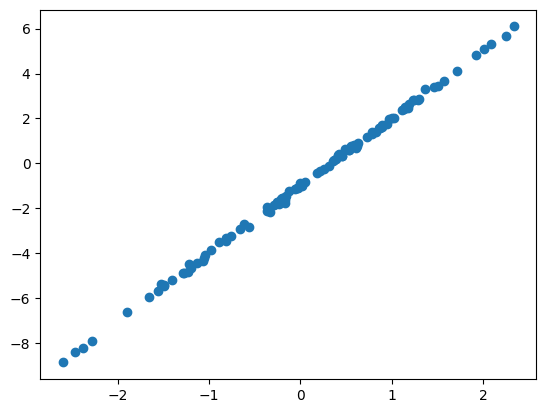

In [79]:
import numpy as np
import matplotlib.pyplot as plt


xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)

In [80]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

The loss function is the squared error

In [81]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

Make a step in the direction of the steepest descent

In [82]:
@jit
def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 3.0011, b: -0.9877


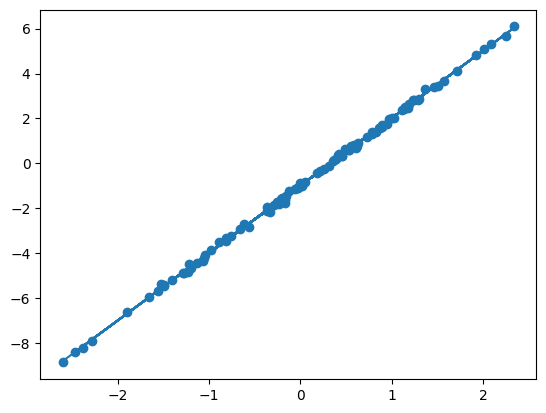

In [83]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.4f}, b: {b:<.4f}")

Note that the old array was untouched, so there is no side-effect:

## Vectorization

Consider the following convolution function

In [84]:
x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

DeviceArray([11., 20., 29.], dtype=float32)

Suppose we need to convolve a batch of weights w to a batch of vectors x

In [85]:
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

In [86]:
print("xs=",xs)
print("ws=",ws)

xs= [[0 1 2 3 4]
 [0 1 2 3 4]]
ws= [[2. 3. 4.]
 [2. 3. 4.]]


The most naive option to compute the convolution on each batch would be to loop over batches

In [87]:
def manually_batched_convolve(xs, ws):
  output = []
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i], ws[i]))
  return jnp.stack(output)

In [88]:
manually_batched_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

In order to batch the computation efficiently, you would normally have to rewrite the function manually to ensure it is done in vectorised form.

This is of course doable, but will require having to change how we deal with indices, axes, etc ...

For instance we can vectorise the computation across the batch dimension as follows:

In [89]:
def manually_vectorised_convolve(xs, ws):
  output = []
  for i in range(1, xs.shape[-1] -1):
    output.append(jnp.sum(xs[:, i-1:i+2] * ws, axis=1))
  return jnp.stack(output, axis=1)

manually_vectorised_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

Automatic vectorization with `vmap`




In [90]:
auto_batch_convolve = jax.vmap(convolve)

auto_batch_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

What if we always want to apply convolve a single set of weights and an entire batch of vectors x?

In [91]:
batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])

batch_convolve_v3(xs, w)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

You can jit vmapped functions:

In [92]:
jitted_batch_convolve = jax.jit(auto_batch_convolve)

jitted_batch_convolve(xs,ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)